# **Pairs trading**

## Juan Diego Tabares

## April 2024

This brief lab explores results for a pairs trading strategy. This exercise is largely based on the course Using Machine Learning in Trading and Finance offered by The NewYork Institute of Finance and Google Cloud.

The analysis involves:

- Downloading historical data for financial assets
- Performing graphical analysis 
- Performing statistical analysis
- Developing a trading strategy
- Displaying the result

In [3]:
# Libraries

import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as si
import seaborn as sb 

In this lab we limit the analysis to the stocks included in the Dow Jones Industrial Average index

In [4]:
# tickers of the Dow index

tickers_dow = si.tickers_dow()

In [6]:
# Function to download the price for each stock. Period of analysis is 2014 - 2024

def get_price(ticker): 
    prices = pd.DataFrame()
    date_rng = pd.date_range(start='2014-01-01', end='2024-03-01', freq='D')
    prices['Date']=date_rng
    prices.set_index('Date', inplace=True)
    prices_list=yf.download(ticker, '2014-01-01', '2024-03-01')['Adj Close'] 
    data = pd.merge(prices, prices_list, left_index=True, right_index=True)
    data.rename(columns = {'Adj Close':ticker}, inplace = True) 
    return data

In [7]:
data_df = list(map(get_price, tickers_dow))
data_df = pd.concat(data_df, axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

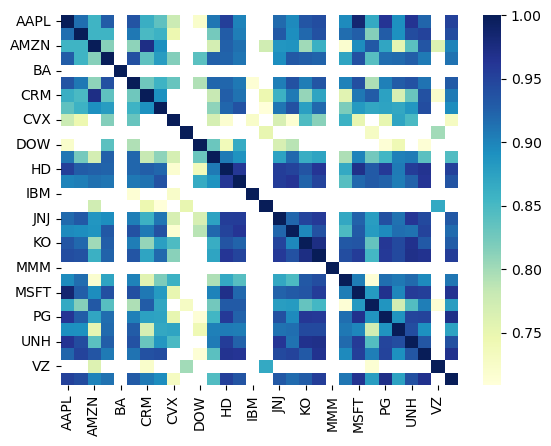

In [8]:
# Correlation analysis to graphically deduce stocks

data_df_corr = data_df.corr()
data_df_corr_plot = sb.heatmap(data_df_corr, cmap="YlGnBu", annot=False, mask = (data_df_corr <= 0.7))
plt.show() 

In [9]:
# function for testing cointegration between the stocks

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [10]:
data_df_na = data_df.dropna()
scores, pvalues, pairs = find_cointegrated_pairs(data_df_na)

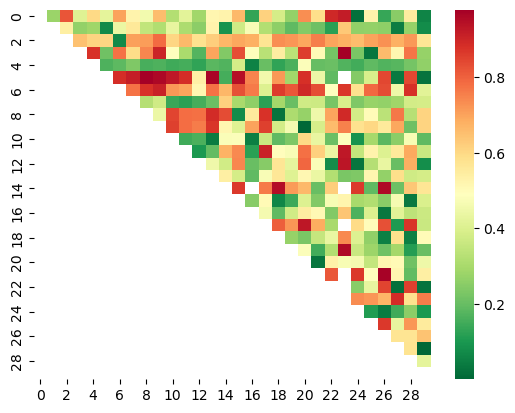

[('AAPL', 'PG'), ('AMGN', 'V'), ('AXP', 'TRV'), ('CAT', 'V'), ('CAT', 'WMT'), ('CVX', 'KO'), ('DIS', 'MMM'), ('DOW', 'HON'), ('DOW', 'JNJ'), ('HD', 'PG'), ('INTC', 'VZ'), ('JNJ', 'UNH'), ('MMM', 'MRK'), ('MSFT', 'V'), ('MSFT', 'WMT'), ('PG', 'UNH'), ('V', 'WMT')]


In [11]:
# Heatmap to show the p-values of the cointegration test between each pair of stocks

m = [0,0.2,0.4,0.6,0.8,1]
sb.heatmap(pvalues, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.98)
                )
plt.show()
print(pairs)

From the correlation result and the cointegration test we select for the strategy two pairs of stocks: AAPL-MSFT and CAT-WMT

In [18]:
data_AAPL = yf.download('AAPL','2014-01-01','2024-03-01')
AAPL=data_AAPL['Adj Close']

data_MSFT = yf.download('MSFT','2014-01-01','2024-03-01')
MSFT=data_MSFT['Adj Close']

data_CAT = yf.download('CAT','2014-01-01','2024-03-01')
CAT=data_CAT['Adj Close']

data_WMT = yf.download('WMT','2014-01-01','2024-03-01')
WMT=data_WMT['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In the first instance we trade the pair AAPL-MSFT

In [19]:
Y=AAPL
X=MSFT

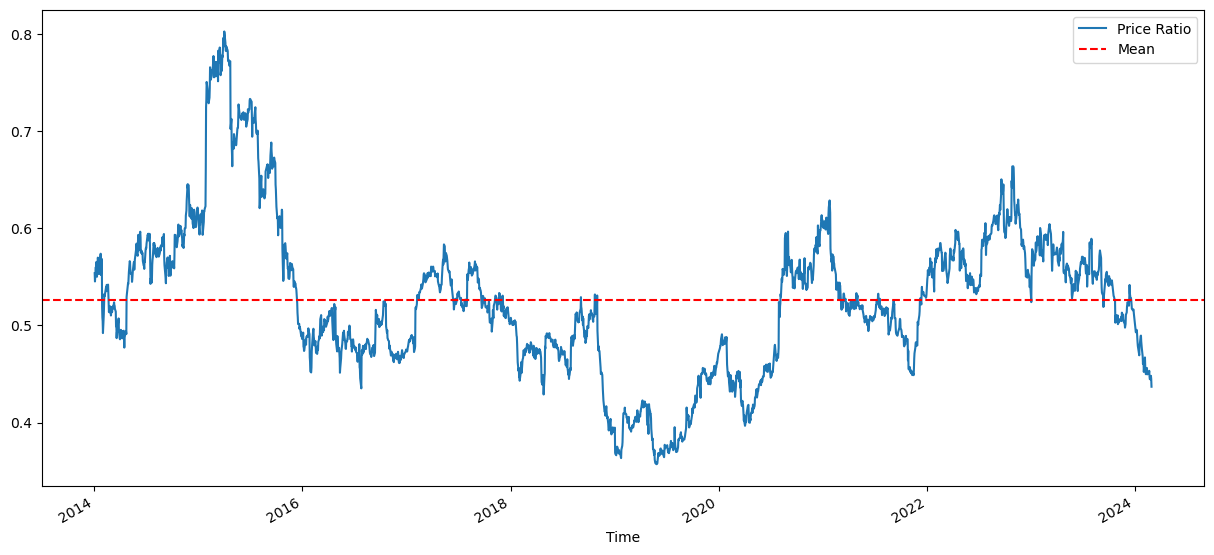

In [20]:
(Y/X).plot(figsize=(15,7)) 
plt.axhline((Y/X).mean(), color='red', linestyle='--') 
plt.xlabel('Time')
plt.legend(['Price Ratio', 'Mean'])
plt.show()

Graphically, the ratio series does not look stationary (fluctuating around its mean). In contrast, the period after 2020 to 2024 looks stationary

In [21]:
score, pvalue, _ = coint(X,Y)

In [22]:
pvalue

0.5781481041153136

In [23]:
X2=AAPL.iloc[1762:]
Y2=MSFT.iloc[1762:]
score2, pvalue2, _ = coint(X2,Y2)
pvalue2

0.494112735106764

In [26]:
# Function to standardized the series

def zscore(series):
    return (series - series.mean()) / np.std(series)

The strategy is implemented buying when the z score is above one standard deviation and selling when it is below one standard deviation

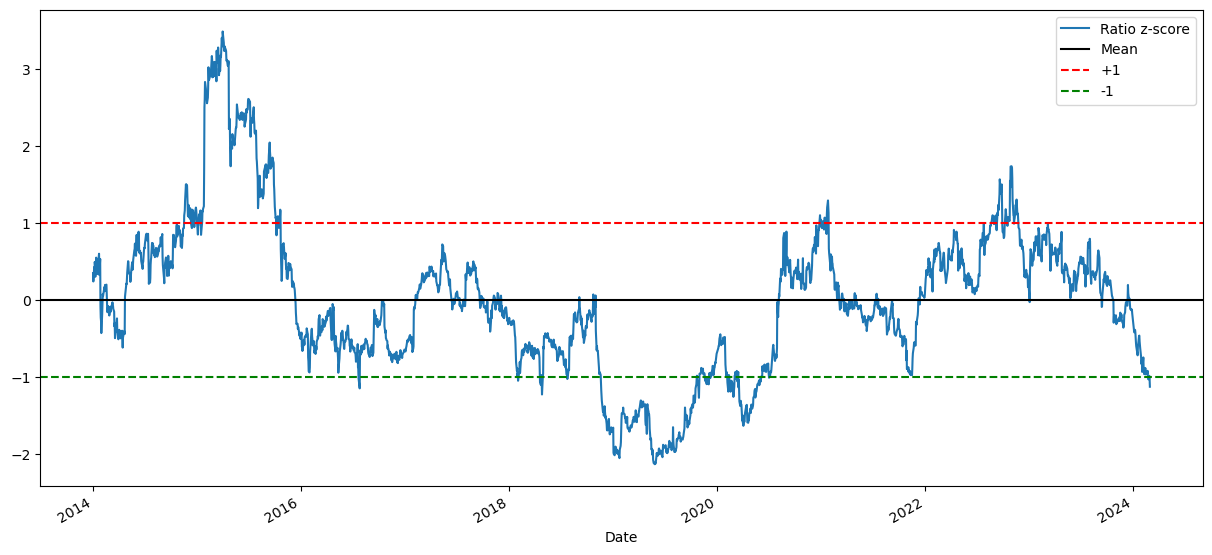

In [28]:
ratios=Y/X
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

In [29]:
# data divided in two blocks to train and test the model

train = ratios[:1762]
test = ratios[1762:]

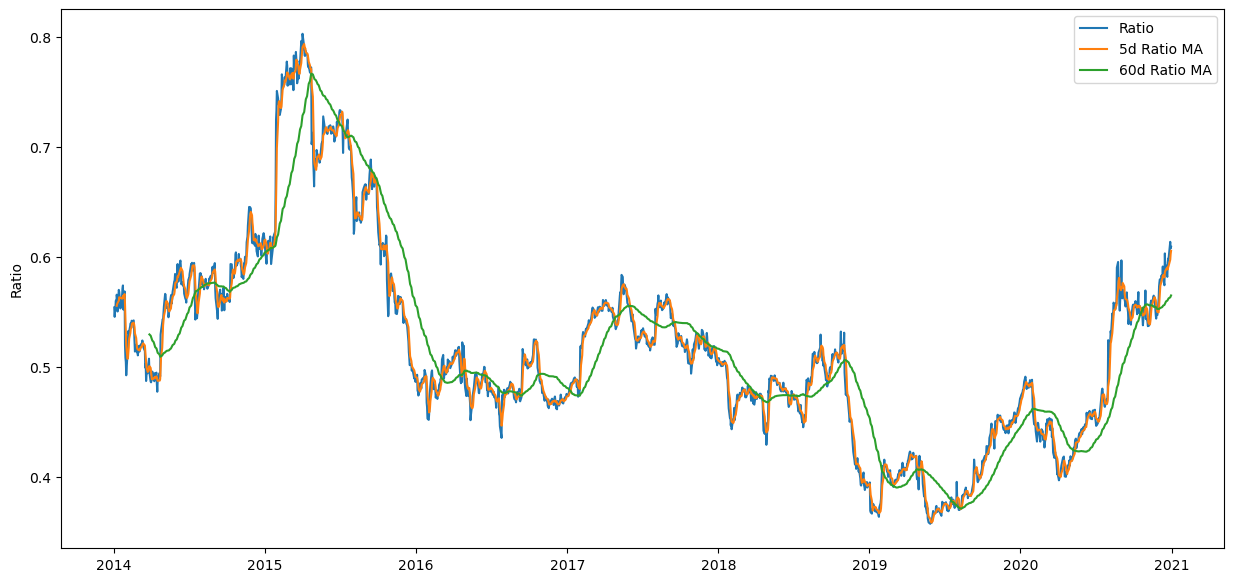

In [31]:
# Moving averages at 5 and 60 periods to use them rather than the mean for the full period

ratios_mavg5 = train.rolling(window=5,
                               center=False).mean()

ratios_mavg60 = train.rolling(window=60,
                               center=False).mean()

std_60 = train.rolling(window=60,
                        center=False).std()

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)

plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

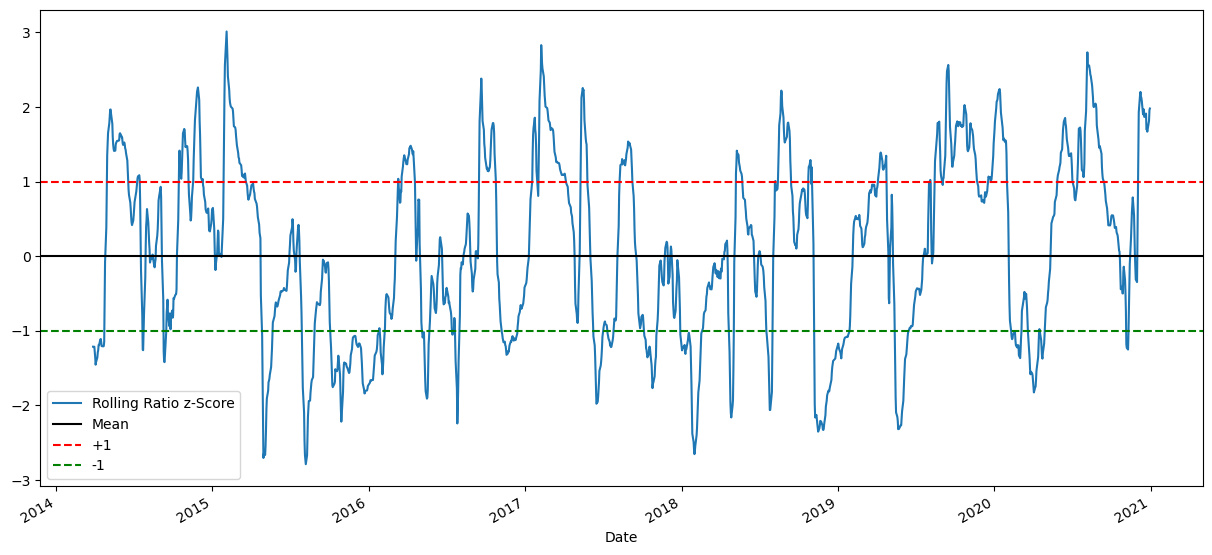

In [32]:
# Take a rolling 60 day standard deviation
std_60 = train.rolling(window=60,center=False).std()
std_60.name = 'std 60d'

# Compute the z score for each day
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
zscore_60_5.name = 'z-score'

plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

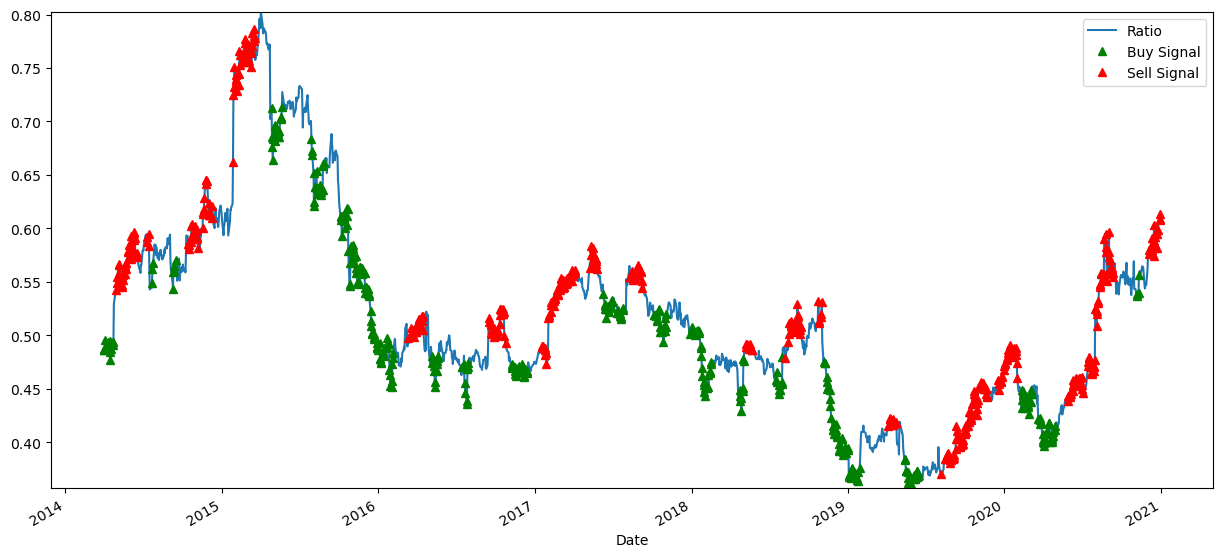

In [33]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))

train[60:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

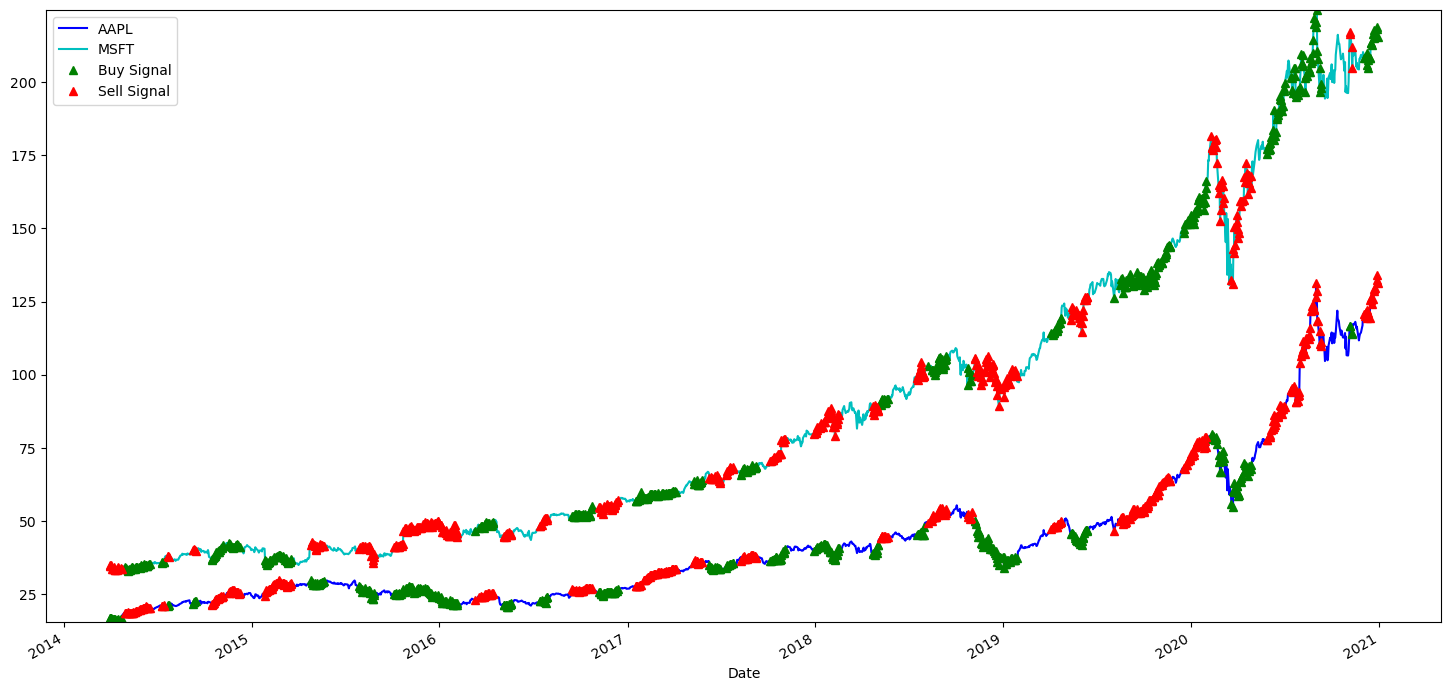

In [34]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))
S1 = AAPL.iloc[:1762]
S2 = MSFT.iloc[:1762]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

plt.legend(['AAPL','MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()

In [35]:
# function to evaluate the strategy's profitability 

def trade(S1, S2, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1*S1[i] + S2[i] * countS2
            countS1 = 0
            countS2 = 0
#         print('Z-score: '+ str(zscore[i]), countS1, countS2, S1[i] , S2[i])
    return money


trade(AAPL.iloc[:1762], MSFT.iloc[:1762], 5, 60)

-355.54688650274494

In [38]:
trade(AAPL.iloc[1762:], MSFT.iloc[1762:], 5, 60)

1390.9477617367336

The strategy got different results for two subperiods being profitable for the period from 2021.

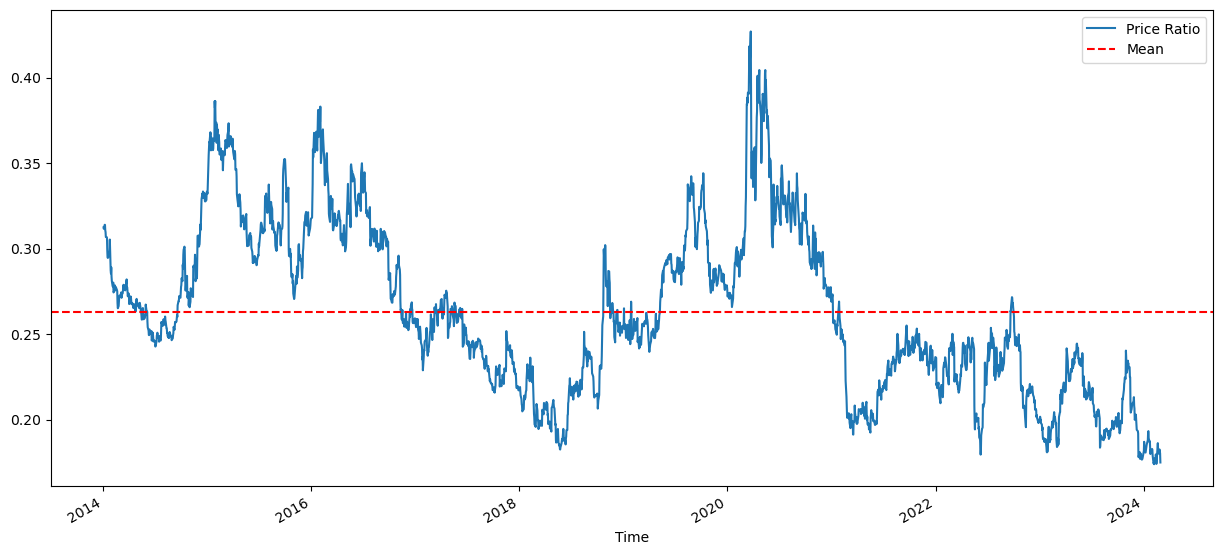

In [41]:
(WMT/CAT).plot(figsize=(15,7)) 
plt.axhline((WMT/CAT).mean(), color='red', linestyle='--') 
plt.xlabel('Time')
plt.legend(['Price Ratio', 'Mean'])
plt.show()

In [42]:
score, pvalue, _ = coint(WMT,CAT)
pvalue

0.1395515744114742

In [40]:
trade(CAT.iloc[:1762], WMT.iloc[:1762], 5, 60)

2104.266373087802

In [39]:
trade(CAT.iloc[1762:], WMT.iloc[1762:], 5, 60)

1580.685916381458

The case for WMT and CAT displays profitability for both periods.